# NN Project 1: Classifying ECG Signals
Rachel Hillner 

Project 1 // Oct. 17, 2022

### Objectives: 
* Build fully connect feed forward NN
* Accurately differentiate between normal heart beats (class 0), ventricular ectopic beats(VEB, class 1), supraventricular ectopic beats (SVEB, class 2), and fusion beats (class 3)
    * Minimize false negatives 
* Compare performace of balanced and skewed class sizes 
* Evaluate performance on dev set

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical


### Classes: 
* 0 - Normal Beat
* 1 - Ventricular Ectopic Beat 
* 2 - SupraVentricular Ectopic Beat
* 3 - Fusion Beat
* 4 - Unknown Beat

In [2]:
# Import data from the 4 .csv files & Drop any rows initially labeled NaN
data1 = pd.read_csv('archive/INCART 2-lead Arrhythmia Database.csv')
data1 = data1.dropna(axis = 0)
data2 = pd.read_csv('archive/MIT-BIH Arrhythmia Database.csv')
data2 = data2.dropna(axis = 0)
data3 = pd.read_csv('archive/MIT-BIH Supraventricular Arrhythmia Database.csv')
data3 = data3.dropna(axis = 0)
data4 = pd.read_csv('archive/Sudden Cardiac Death Holter Database.csv')
data4 = data4.dropna(axis = 0)

# Ensure data columns align and append into 1 data set
if list(data1.columns) == list(data2.columns) == list(data3.columns) == list(data4.columns):
    data = data1.append(data2.append(data3.append(data4, ignore_index=True), ignore_index=True),ignore_index=True)

# Clean
data = data.drop('record', axis=1)    # Drop 'record' column
data['type'] = data['type'].replace(list(data.type.unique()), ['0','1','2','3','4']) # Get labels and replace them with numeric values

data.head

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<bound method NDFrame.head of        type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
0         0     163.0      165.0  0.069610 -0.083281  0.614133 -0.392761   
1         0     165.0      166.0 -0.097030  0.597254 -0.078704 -0.078704   
2         0     166.0      102.0  0.109399  0.680528 -0.010649 -0.010649   
3         1     102.0      231.0  0.176376  0.256431 -0.101098 -0.707525   
4         0     231.0      165.0  0.585577  0.607461 -0.083499 -0.083499   
...     ...       ...        ...       ...       ...       ...       ...   
712817    0      76.0      148.0 -0.345439  1.086720 -0.213846 -0.213846   
712818    0     148.0      104.0  0.095040  0.804837  0.211167  0.211167   
712819    0      32.0       22.0  1.603278 -0.518048 -0.531231 -0.531231   
712820    0      56.0       82.0 -0.942216 -1.074539 -0.955163 -1.249941   
712821    0      60.0       64.0  1.085070 -0.027911  0.284400 -0.402152   

         0_qPeak  0_qrs_interval  0_pq_interval  ...   1_

In [31]:
data.columns

Index(['type', '0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak',
       '0_sPeak', '0_qPeak', '0_qrs_interval', '0_pq_interval',
       '0_qt_interval', '0_st_interval', '0_qrs_morph0', '0_qrs_morph1',
       '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR',
       '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval',
       '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0',
       '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4'],
      dtype='object')

In [17]:
# Count class split
split = np.array(np.zeros([5,1]))
split[0] = data[data.type == '0'].shape[0]
split[1] = data[data.type == '1'].shape[0]
split[2] = data[data.type == '2'].shape[0]
split[3] = data[data.type == '3'].shape[0]
split[4] = data[data.type == '4'].shape[0]

# (split / data.shape[0])*100

| Class | Spread | Class |
| --- | --- | --- |
| 0 | 90.4% | Normal |
| 1 | 6.76% | VEB |
| 2 | 2.60% | SVEB |
| 3 | 0.18% | Fusion |
| 4 | 0.02% | Unknown |

I predict that the large discrepancy in class sizes may result in overclassification of normal hear beats. False negatives can be detrimental to the health of a patient. I will take 2 initial approaches with this problem: 
* 1: Use existing class spread
* 2: try to equalize class spread

I wonder if equalizing the classes will affect NN performance?

In [18]:
# Equalize spread by randomly getting rid of 95% of class 0 
dataE = data.drop(data[data['type'] == '0'].sample(frac=.95).index)

# lets also get rid of the unknowns 
dataE = dataE[dataE.type != '4']

# Count new class split
splitE = np.array(np.zeros([5,1]))
splitE[0] = dataE[dataE.type == '0'].shape[0]
splitE[1] = dataE[dataE.type == '1'].shape[0]
splitE[2] = dataE[dataE.type == '2'].shape[0]
splitE[3] = dataE[dataE.type == '3'].shape[0]
splitE[4] = dataE[dataE.type == '4'].shape[0]

# (splitE / dataE.shape[0])*100

| Class | Spread | Class |
| --- | --- | --- |
| 0 | 32.2% | Normal |
| 1 | 48.1% | VEB |
| 2 | 18.5% | SVEB |
| 3 | 1.25% | Fusion |

In [19]:
# Splitting data into predictors (x) and labels (y)
y = (dataE['type'])
X = dataE.drop(['type'], axis = 1)
Xnorm = dataE.drop(['type'], axis = 1)

# Normalize X between 0 and 1 wrt to each column
min_max_scaler = preprocessing.MinMaxScaler()
Xnorm = min_max_scaler.fit_transform(X)
Xnorm = pd.DataFrame(Xnorm, columns = X.columns)

# splitting normalized data into train/test/dev sets (60/20/20)
(trainX, testX, trainY, testY) = train_test_split(Xnorm, y, test_size = 0.40, random_state = 1)
(devX, testX, devY, testY) = train_test_split(testX, testY, test_size = 0.50, random_state = 1)

# Confirm shapes
print('Training set dimensions')
print(trainX.shape)
print(trainY.shape)

print('\nDev set dimensions')
print(devX.shape)
print(devY.shape)

print('\nTest set dimensions')
print(testX.shape)
print(testY.shape)


Training set dimensions
(60122, 32)
(60122,)

Dev set dimensions
(20041, 32)
(20041,)

Test set dimensions
(20041, 32)
(20041,)


In [13]:
# Build Feed Forward NN
# Inputs:
#   layers - a list of numbers of neurons in each layer
#   alpha - learning rate
#   lambda1 - L1 penalty coefficient
#   lambda2 - L2 penalty coefficient
#   batchSize - size of mini-batches for SGD
#   gamma - momentum coefficient (between 0 and 1)
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'
#   activation function - string to choose which function to use:
#     'sigmoid'
#     'hyperbolic tangent'
#     'relu'


class FFuuNN:
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', loss = 'sum-of-squares', activation = 'sigmoid'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # loss function
        self.loss = loss
        
        # activation function
        self.activation = activation
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as uniform random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the activation derivative (where x is the INPUT to activation function)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
    # define the HYPERBOLIC TANGENT activation function
    def hyTan(self, x):
        return (2/(1 + np.exp(-2*x))) - 1
    
    # define the activation HYPERBOLIC TANGENT derivative (where x is the INPUT to activation function)
    def hyTanDeriv(self, z):
        return 1 - z**2
    
    # define the RELU activation function
    def reLu(self, x):
        return np.maximum(0, x)
    
    # define the activation RELU derivative (where x is the INPUT to activation function)
    # 0 if x less than 0, 1 if x greater than 0
    def reLuDeriv(self, z):
        z[z <= 0 ] = 0
        z[z > 0] = 1
        return z
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = to_categorical(y)
        
        # initialize previous-step gradient
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))

        for epoch in np.arange(0,epochs):
            
            alpha = self.alpha
            
            # use annealing
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
                            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    # feed through one layer and apply activation
                    net = A[layer].dot(self.W[layer])
                    # if statement based on user input
                    if self.activation == 'sigmoid':
                        out = self.sigmoid(net)
                    elif self.activation == 'hyperbolic tangent':
                        out = self.hyTan(net)
                    elif self.activation == 'relu':
                        out = self.reLu(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    # if statement based on user input
                    if self.activation == 'sigmoid':
                        D = [error * self.sigmoidDerivative(A[-1])]
                    elif self.activation == 'hyperbolic tangent':
                        D = [error * self.hyTanDeriv(A[-1])]
                    elif self.activation == 'relu':
                        D = [error * self.reLuDeriv(A[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    # if statement based on user input
                    if self.activation == 'sigmoid':
                        delta = delta * self.sigmoidDerivative(A[layer])
                    elif self.activation == 'hyperbolic tangent':
                        delta = delta * self.hyTanDeriv(A[layer])
                    elif self.activation == 'relu':
                        delta = delta * self.reLuDeriv(A[layer])
                    
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    
                    # compute the gradient
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    # use momentum (if gamma > 0) to make weight update
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]

            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                
                # compute the loss
                loss = self.computeLoss(X,y)

                # if we choose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    
                    print('Epoch =', epoch + 1, '\tloss =', loss)
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print('Epoch =', epoch + 1, '\tloss =', loss)

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            if self.activation == 'sigmoid':
                p = self.sigmoid(np.dot(p, self.W[layer]))
            elif self.activation == 'hyperbolic tangent':
                p = self.hyTan(np.dot(p, self.W[layer]))
            elif self.activation == 'relu':
                p = self.reLu(np.dot(p, self.W[layer]))
            
        # return the predictions
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        
        # initialize data to the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
        
        # add L1 and L2 penalty
        L1penalty = 0
        L2penalty = 0
        
        # add up L1 and L2 penalties from each layer
        for layer in np.arange(0,len(self.W)):
            L1penalty += np.sum(np.abs(self.W[layer]))
            L2penalty += np.sum(self.W[layer] ** 2)
        
        # L1 and L2 penalties to the loss
        loss += (self.lambda1 / X.shape[0]) * L1penalty
        loss += (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

# Benchmark: Logistic Regression
Unequal class sizes, no class of unknowns


Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.99      0.97    129137
           1       0.85      0.65      0.74      9495
           2       0.37      0.01      0.03      3646
           3       0.85      0.07      0.12       258

    accuracy                           0.95    142536
   macro avg       0.75      0.43      0.47    142536
weighted avg       0.93      0.95      0.93    142536


Confusion Matrix:



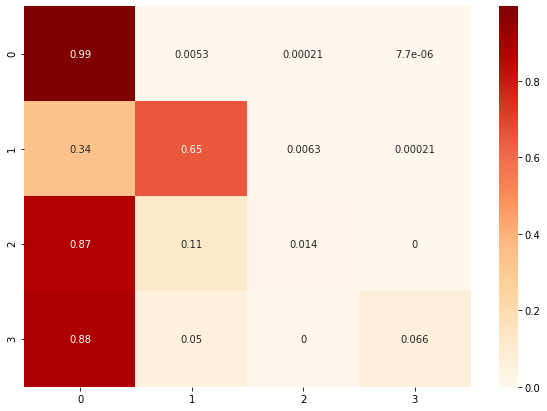

In [59]:
from sklearn.linear_model import LogisticRegression

# Train & Pred. w/ Log. Reg.  
logReg = LogisticRegression(max_iter=10000)
y_pred = logReg.fit(trainX, trainY).predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, y_pred))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, y_pred, normalize='true'), cmap='OrRd', annot = True)

95% accuracy overall, purely because it wanted to classify everything as class 0. This metric is misleading with skewed class sizes. Performed horribly when classifying classes 2 and 3 (didn't do too hot with class 1 either). 

#### Equal class sizes, no unknowns


Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.88      0.84      6330
           1       0.86      0.88      0.87      9644
           2       0.69      0.53      0.60      3807
           3       0.89      0.21      0.34       260

    accuracy                           0.81     20041
   macro avg       0.81      0.63      0.66     20041
weighted avg       0.80      0.81      0.80     20041


Confusion Matrix:



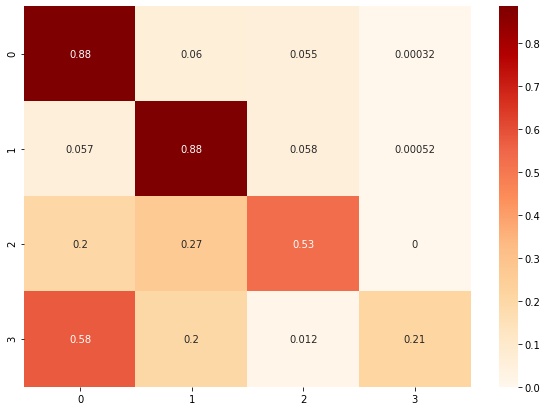

In [233]:
# Train & Pred. w/ Log. Reg.  
logReg = LogisticRegression(max_iter=10000)
y_pred = logReg.fit(trainX, trainY).predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, y_pred))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, y_pred, normalize='true'), cmap='OrRd', annot = True)

Overall, logistic regression performed decently. It did well classifying VEB (class 1) with 88% accuracy and only 5.7% being classified as normal beats (class 0). It struggled with SVEB (class 2) at 53% accuracy and 20% being classified as normal beats (class 0). Fusion beats (class 3) were classified the worst at 21% accuracy. More concerning is that the majority of fusion beats, at 58%, were classified as normal beats (class 0). This would particularly concerning for a patient.

### Now for NN training

# Training Non-Equal Class Sizes

In [56]:
# lets also get rid of the unknowns 
data = data[data.type != '4']

# Splitting data into predictors (x) and labels (y)
y = (data['type'])
X = data.drop(['type'], axis = 1)
Xnorm = data.drop(['type'], axis = 1)

# Normalize X between 0 and 1 wrt to each column
min_max_scaler = preprocessing.MinMaxScaler()
Xnorm = min_max_scaler.fit_transform(X)
Xnorm = pd.DataFrame(Xnorm, columns = X.columns)

# splitting normalized data into train/test/dev sets (60/20/20)
(trainX, testX, trainY, testY) = train_test_split(Xnorm, y, test_size = 0.40, random_state = 1)
(devX, testX, devY, testY) = train_test_split(testX, testY, test_size = 0.50, random_state = 1)

# Confirm shapes
print('Training set dimensions')
print(trainX.shape)
print(trainY.shape)

print('\nDev set dimensions')
print(devX.shape)
print(devY.shape)

print('\nTest set dimensions')
print(testX.shape)
print(testY.shape)

Training set dimensions
(427607, 32)
(427607,)

Dev set dimensions
(142536, 32)
(142536,)

Test set dimensions
(142536, 32)
(142536,)


Epoch = 10 	loss = 13679.171282376285
Epoch = 20 	loss = 11105.327292610218
Epoch = 30 	loss = 9836.52813315744
Epoch = 40 	loss = 8287.087291860673
Epoch = 50 	loss = 9560.39282576641
Epoch = 60 	loss = 8106.102461516654
Epoch = 70 	loss = 8593.036037402642
Epoch = 80 	loss = 8748.84094801298
Epoch = 90 	loss = 6246.859777001962
Epoch = 100 	loss = 8270.865435774573
Epoch = 110 	loss = 7366.630881021973
Epoch = 120 	loss = 7533.230770554579
Epoch = 130 	loss = 9305.825456817376
Epoch = 140 	loss = 5581.604070760553
Epoch = 150 	loss = 6012.269835328138
Epoch = 160 	loss = 5979.764559577826
Epoch = 170 	loss = 5828.556291790146
Epoch = 180 	loss = 6774.822610212297
Epoch = 190 	loss = 5253.58153643202
Epoch = 200 	loss = 5575.297820354692
Epoch = 210 	loss = 6640.236002146655
Epoch = 220 	loss = 5438.631580178072
Epoch = 230 	loss = 5365.124877395228
Epoch = 240 	loss = 6904.922683855336
Epoch = 250 	loss = 5900.086436857033
Epoch = 260 	loss = 5418.349007991246
Epoch = 270 	loss = 512

array([[0.99, 0.  , 0.  , 0.  ],
       [0.04, 0.95, 0.01, 0.  ],
       [0.28, 0.03, 0.69, 0.  ],
       [0.34, 0.19, 0.02, 0.44]])

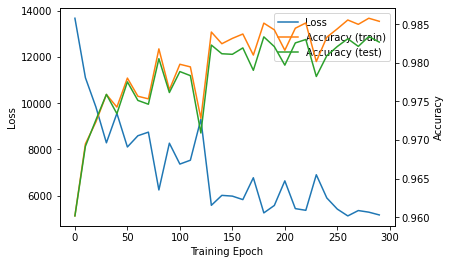

In [58]:
# No l1 or l2 penalties to compare

# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 0.0, 32, 0.9, ['Glorot', 'normal'], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

This model classified nearly all normal beats as class normal with 99% in class accuracy. It performed well with class 1 (VEB) as well. However, when it came to the smaller classes (class 2 and 3 at 2.6% and 0.2% of the data), the model did not perform well. I believe that a similair (if not better) performance can be achieved at a lower computational expense by balancing the class sizes. This model took very long to train (~ 30 minutes, but I did not time it exactly) as opposed to the smaller, balanced dataset (~ 10 minutes to train for 1000 epoch). Another downfall, is that given only ~0.2% of the data is classified as fusion beats, then the model could have an accuracy of 99.8% and still classify every fusion beat incorrectly. 

# Training: Equalized Class Sizes 
* Using the FFuuNN class defined above that we built in class (& Used in HW2)
* Train with the unknown class set

<ipython-input-133-04cc2bc7bc3a>:361: RuntimeWarning: invalid value encountered in log
  loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))


Epoch = 1 	loss = 839825.1979837405
Epoch = 2 	loss = 724463.7848958154
Epoch = 3 	loss = 638407.6738723655
Epoch = 4 	loss = 460439.16168300755
Epoch = 5 	loss = 113033.50120592462
Epoch = 6 	loss = 112990.92711718692
Epoch = 7 	loss = 113079.75183020247
Epoch = 8 	loss = 115133.3876324282
Epoch = 9 	loss = 118562.5976574158
Epoch = 10 	loss = 125838.5486539491
Epoch = 11 	loss = 127782.03411654587
Epoch = 12 	loss = 83671.89724973441
Epoch = 13 	loss = 81823.73373064386
Epoch = 14 	loss = 79168.41785596665
Epoch = 15 	loss = 80234.97597097294
Epoch = 16 	loss = 78815.62841660912
Epoch = 17 	loss = 79460.20865103725
Epoch = 18 	loss = 78255.26166201822
Epoch = 19 	loss = 77361.22235647477
Epoch = 20 	loss = 75652.73593349312
Epoch = 21 	loss = 72483.09794550097
Epoch = 22 	loss = 68358.84672425223
Epoch = 23 	loss = 66738.61463490514
Epoch = 24 	loss = 64495.96246535471
Epoch = 25 	loss = 65448.051772920226
Epoch = 26 	loss = 64080.89181369942
Epoch = 27 	loss = 69870.2852812447
Epoch

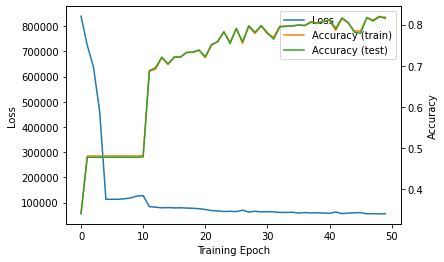

In [150]:
# fit the model to the training data
model = FFuuNN([32, 24, 16, 12, 5], 0.001, 'none', 0.0, 20.0, 32, 0.0, ['normal', 100], 'cross-entropy', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test Confusion Matrix Normalized by Percent Correct by Class:


array([[0.95, 0.02, 0.03, 0.  , 0.  ],
       [0.08, 0.87, 0.05, 0.  , 0.  ],
       [0.3 , 0.2 , 0.5 , 0.  , 0.  ],
       [0.89, 0.11, 0.  , 0.  , 0.  ],
       [0.22, 0.67, 0.11, 0.  , 0.  ]])

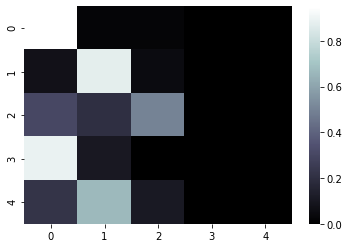

In [154]:
print('Test Confusion Matrix Normalized by Percent Correct by Class:')
sn.heatmap(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), cmap = 'bone')
np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

| Normal | VEB | SVEB | Fusion |
| --- | --- | --- | --- |
| 95% | 87% | 50% | 0.0% |

No samples were predicted to be either fusion beats or unknown. Unknown is not too worrying, as I am unsure the reason they are unknown. I should drop the unknown class because I don't need to train a NN to not know somwthing, but I forgot to drop it before the next step. However, 89% of fusion beats being classied as Normal is concerning. Before changing things, let me increase epoch to see if the loss continues to drop. Also, changing the loss function to sum of squares to aviod the runtime warning. 

Epoch = 10 	loss = 18811.065093030353
Epoch = 20 	loss = 13561.530995652032
Epoch = 30 	loss = 10622.257731093938
Epoch = 40 	loss = 10268.843798033498
Epoch = 50 	loss = 9560.114499628093
Epoch = 60 	loss = 8880.728991215465
Epoch = 70 	loss = 8741.380777478691
Epoch = 80 	loss = 8030.345028271131
Epoch = 90 	loss = 7750.342336761601
Epoch = 100 	loss = 7407.981306644218
Epoch = 110 	loss = 7247.881022517291
Epoch = 120 	loss = 7077.803376915024
Epoch = 130 	loss = 6698.01230744137
Epoch = 140 	loss = 6799.228628232061
Epoch = 150 	loss = 6409.148683635024
Training set accuracy
0.8633902471432368
Test set accuracy
0.8641753861484803


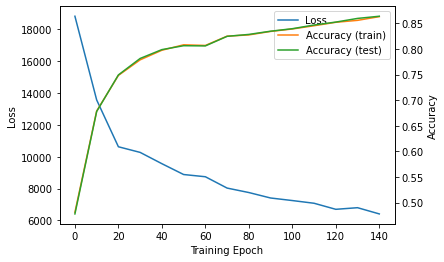

In [158]:
# fit the model to the training data
model = FFuuNN([32, 24, 16, 12, 5], 0.001, 'none', 0.0, 20.0, 32, 0.0, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 150, 10) # Only update every 10 epoch so not printing so much 

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test Confusion Matrix Normalized by Percent Correct by Class:


array([[0.92, 0.03, 0.05, 0.  , 0.  ],
       [0.04, 0.9 , 0.05, 0.  , 0.  ],
       [0.16, 0.12, 0.72, 0.  , 0.  ],
       [0.61, 0.18, 0.01, 0.2 , 0.  ],
       [0.22, 0.56, 0.22, 0.  , 0.  ]])

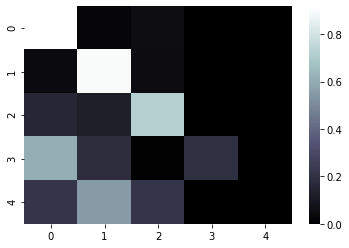

In [159]:
print('Test Confusion Matrix Normalized by Percent Correct by Class:')
sn.heatmap(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), cmap = 'bone')
np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

| Normal | VEB | SVEB | Fusion |
| --- | --- | --- | --- |
| 92% | 90% | 72% | 20% |

It was able to make some form of distinction with fusion beats, however, a large portion of fusion beats are still classified as normal. Overall accuracy increased by ~5%. This can be reflected in the 12% increase in accuracy of classification of SVEB (from 50% to 72%). Lets increase epoch once more to see if it plateaus. 

Epoch = 10 	loss = 18795.61396175039
Epoch = 20 	loss = 13084.423525220425
Epoch = 30 	loss = 10775.743769739258
Epoch = 40 	loss = 9692.260108052264
Epoch = 50 	loss = 9730.521302686459
Epoch = 60 	loss = 8838.500770172695
Epoch = 70 	loss = 8571.101615501007
Epoch = 80 	loss = 8396.599946879902
Epoch = 90 	loss = 8362.299233871507
Epoch = 100 	loss = 8224.519488024023
Epoch = 110 	loss = 8517.628441061122
Epoch = 120 	loss = 8015.484419632368
Epoch = 130 	loss = 7599.153136261055
Epoch = 140 	loss = 7699.150745487689
Epoch = 150 	loss = 6918.77910219375
Epoch = 160 	loss = 6676.8193494247325
Epoch = 170 	loss = 6438.932619635287
Epoch = 180 	loss = 6603.127631377162
Epoch = 190 	loss = 7364.185693728191
Epoch = 200 	loss = 6044.15559153319
Epoch = 210 	loss = 5815.287071477519
Epoch = 220 	loss = 5863.281243215838
Epoch = 230 	loss = 5622.278571754484
Epoch = 240 	loss = 5618.69138480429
Epoch = 250 	loss = 5809.050296543631
Epoch = 260 	loss = 5657.69329689782
Epoch = 270 	loss = 57

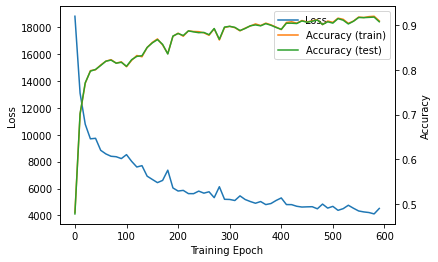

In [162]:
# fit the model to the training data
model = FFuuNN([32, 24, 16, 12, 5], 0.001, 'none', 0.0, 20.0, 32, 0.0, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 600, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test Confusion Matrix Normalized by Percent Correct by Class:


array([[0.91, 0.04, 0.05, 0.  , 0.  ],
       [0.01, 0.97, 0.02, 0.  , 0.  ],
       [0.08, 0.13, 0.79, 0.  , 0.  ],
       [0.28, 0.31, 0.02, 0.39, 0.  ],
       [0.11, 0.72, 0.17, 0.  , 0.  ]])

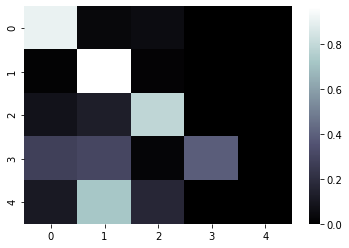

In [163]:
print('Test Confusion Matrix Normalized by Percent Correct by Class:')
sn.heatmap(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), cmap = 'bone')
np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

| Normal | VEB | SVEB | Fusion |
| --- | --- | --- | --- |
| 91% | 97% | 79% | 39% |

Overall accuracy increased once again, this time by ~4%. Accuracy of classification for each class also increased (expect for normal). Lets try increase NN size. 

Epoch = 10 	loss = 18713.994241080734
Epoch = 20 	loss = 12116.002416175337
Epoch = 30 	loss = 10170.788562852356
Epoch = 40 	loss = 9851.678287794546
Epoch = 50 	loss = 8987.331367143788
Epoch = 60 	loss = 8686.908513842374
Epoch = 70 	loss = 8481.027662736493
Epoch = 80 	loss = 8472.38077969141
Epoch = 90 	loss = 8124.665309696822
Epoch = 100 	loss = 8336.562258370379
Epoch = 110 	loss = 8022.560679290334
Epoch = 120 	loss = 7511.544464861419
Epoch = 130 	loss = 7184.8236498663855
Epoch = 140 	loss = 6849.768887075704
Epoch = 150 	loss = 7042.492329038232
Epoch = 160 	loss = 6957.474726239322
Epoch = 170 	loss = 6213.994171699386
Epoch = 180 	loss = 6362.284293433013
Epoch = 190 	loss = 6917.718538399039
Epoch = 200 	loss = 5931.38618847058
Epoch = 210 	loss = 5927.645358994961
Epoch = 220 	loss = 5797.777431623606
Epoch = 230 	loss = 5713.455580071618
Epoch = 240 	loss = 5676.051029791358
Epoch = 250 	loss = 5849.497540775841
Epoch = 260 	loss = 5353.2541438998705
Epoch = 270 	loss 

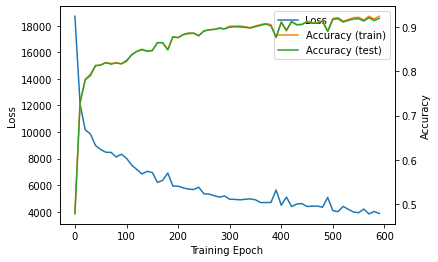

In [164]:
# Use FFuuNN class defined above that we built in class (& Used in HW2)

# fit the model to the training data
model = FFuuNN([32, 32, 24, 12, 5], 0.001, 'none', 0.0, 20.0, 32, 0.0, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 600, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test Confusion Matrix Normalized by Percent Correct by Class:


array([[0.95, 0.02, 0.03, 0.  , 0.  ],
       [0.02, 0.95, 0.02, 0.  , 0.  ],
       [0.12, 0.07, 0.81, 0.  , 0.  ],
       [0.3 , 0.22, 0.03, 0.44, 0.  ],
       [0.11, 0.67, 0.22, 0.  , 0.  ]])

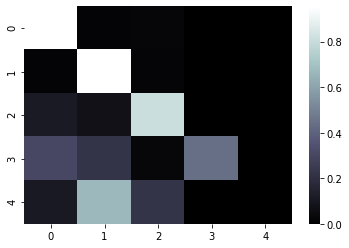

In [165]:
print('Test Confusion Matrix Normalized by Percent Correct by Class:')
sn.heatmap(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), cmap = 'bone')
np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Increasing NN size helped. Now bigger

Epoch = 10 	loss = 18777.83457539921
Epoch = 20 	loss = 12670.198418151753
Epoch = 30 	loss = 10613.179270686385
Epoch = 40 	loss = 9698.629070382316
Epoch = 50 	loss = 9428.388379074542
Epoch = 60 	loss = 8764.413053230817
Epoch = 70 	loss = 8388.060009138371
Epoch = 80 	loss = 8332.295298686806
Epoch = 90 	loss = 7985.8823406437605
Epoch = 100 	loss = 7985.779961649295
Epoch = 110 	loss = 7442.668934744356
Epoch = 120 	loss = 7392.424780151672
Epoch = 130 	loss = 7080.109148481817
Epoch = 140 	loss = 7160.410630039677
Epoch = 150 	loss = 6639.146552893996
Epoch = 160 	loss = 6279.95191794411
Epoch = 170 	loss = 6137.238406784207
Epoch = 180 	loss = 6006.582337455792
Epoch = 190 	loss = 6103.004001589155
Epoch = 200 	loss = 5739.96510456837
Epoch = 210 	loss = 5961.87285725543
Epoch = 220 	loss = 5583.919003374247
Epoch = 230 	loss = 5512.3544010507785
Epoch = 240 	loss = 5351.975283134724
Epoch = 250 	loss = 5286.123879853186
Epoch = 260 	loss = 5337.258364574091
Epoch = 270 	loss = 

array([[0.95, 0.02, 0.03, 0.  , 0.  ],
       [0.02, 0.96, 0.02, 0.  , 0.  ],
       [0.1 , 0.07, 0.83, 0.  , 0.  ],
       [0.26, 0.23, 0.05, 0.45, 0.  ],
       [0.17, 0.67, 0.17, 0.  , 0.  ]])

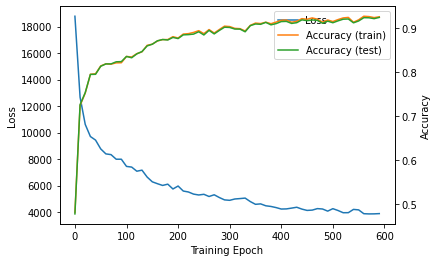

In [166]:
# fit the model to the training data
model = FFuuNN([32, 48, 24, 12, 5], 0.001, 'none', 0.0, 20.0, 32, 0.0, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 600, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Increased sized helped again. Lets make it bigger again and add momentum. 

Epoch = 10 	loss = 8930.331738875646
Epoch = 20 	loss = 7675.750709770808
Epoch = 30 	loss = 6129.011435775524
Epoch = 40 	loss = 6379.389614701604
Epoch = 50 	loss = 6134.9746408227975
Epoch = 60 	loss = 4732.743613486698
Epoch = 70 	loss = 5326.577465582092
Epoch = 80 	loss = 4646.026635102252
Epoch = 90 	loss = 4832.089022507388
Epoch = 100 	loss = 4468.122339238661
Epoch = 110 	loss = 4638.210159774778
Epoch = 120 	loss = 4143.238568121287
Epoch = 130 	loss = 4024.9383392530767
Epoch = 140 	loss = 3640.771606351897
Epoch = 150 	loss = 3835.496159113848
Epoch = 160 	loss = 3725.648763684081
Epoch = 170 	loss = 3420.1405799594304
Epoch = 180 	loss = 5462.912089143199
Epoch = 190 	loss = 3430.0869541462393
Epoch = 200 	loss = 5096.8636619466815
Epoch = 210 	loss = 3686.9645304047654
Epoch = 220 	loss = 3959.5396388609456
Epoch = 230 	loss = 3338.456081315263
Epoch = 240 	loss = 3617.203684479742
Epoch = 250 	loss = 4500.48285055769
Epoch = 260 	loss = 3128.144864537469
Epoch = 270 	lo

array([[0.89, 0.02, 0.1 , 0.  , 0.  ],
       [0.01, 0.97, 0.02, 0.  , 0.  ],
       [0.04, 0.07, 0.89, 0.  , 0.  ],
       [0.15, 0.24, 0.06, 0.56, 0.  ],
       [0.11, 0.67, 0.22, 0.  , 0.  ]])

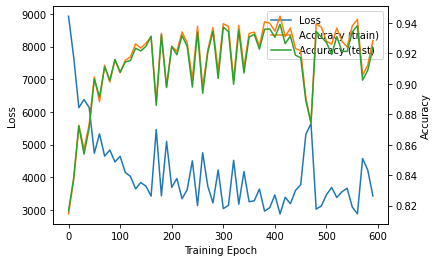

In [167]:
# fit the model to the training data
model = FFuuNN([32, 64, 32, 16, 5], 0.001, 'none', 0.0, 20.0, 32, 0.9, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 600, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Started going crazy at 150 epoch. Overall accuracy stayed comparable. Increasing NN size continues to increase accuracy, specifically with the fusion beats group. Lets finally drop the unknown class (I had been forgetting to do so earlier)

## Equal class sizes; No unknowns 

no unknowns!
Epoch = 10 	loss = 9041.561822974538
Epoch = 20 	loss = 8315.520735996239
Epoch = 30 	loss = 6530.790983185662
Epoch = 40 	loss = 6941.782402383198
Epoch = 50 	loss = 4983.429251147675
Epoch = 60 	loss = 4755.414761494959
Epoch = 70 	loss = 4642.920029594182
Epoch = 80 	loss = 4450.65894029988
Epoch = 90 	loss = 4172.585650440084
Epoch = 100 	loss = 3679.6177203674883
Epoch = 110 	loss = 4622.058619821371
Epoch = 120 	loss = 3839.57896312807
Epoch = 130 	loss = 3816.754856932955
Epoch = 140 	loss = 4288.257256043253
Epoch = 150 	loss = 4533.22442241872
Epoch = 160 	loss = 3419.6869204912996
Epoch = 170 	loss = 3806.19719717658
Epoch = 180 	loss = 4172.9392601895315
Epoch = 190 	loss = 3127.1446948937755
Epoch = 200 	loss = 3044.197911190099
Epoch = 210 	loss = 3351.9991198269418
Epoch = 220 	loss = 3705.601723965008
Epoch = 230 	loss = 2974.590410036048
Epoch = 240 	loss = 3292.6969796453322
Epoch = 250 	loss = 3002.9139220105035
Epoch = 260 	loss = 3197.9217843758283
Epoc

array([[0.94, 0.01, 0.04, 0.  ],
       [0.01, 0.97, 0.02, 0.  ],
       [0.04, 0.05, 0.91, 0.  ],
       [0.22, 0.24, 0.05, 0.49]])

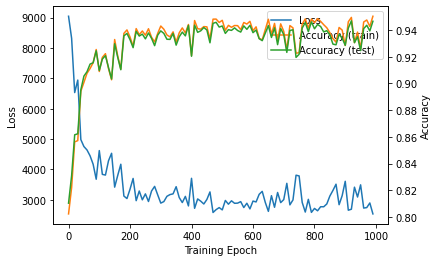

In [34]:
print('no unknowns!')

# fit the model to the training data
model = FFuuNN([32, 64, 32, 16, 4], 0.001, 'none', 0.0, 20.0, 32, 0.9, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 1000, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Dropping the unknown class appeared to decrease the amount of drasatic oscillations. Moreover, I don't belive that increasing the epoch was worth the computational cost. Accuracy increased overall, however, classification of fusion beats decreased by 4%, with more being classified as normal. Lets increase NN size. 

no unknowns!
Epoch = 10 	loss = 9299.55229503753
Epoch = 20 	loss = 7063.129212800893
Epoch = 30 	loss = 6138.957830445146
Epoch = 40 	loss = 6748.901139393741
Epoch = 50 	loss = 5285.80507968411
Epoch = 60 	loss = 4943.7005245538985
Epoch = 70 	loss = 4728.986626479823
Epoch = 80 	loss = 4694.870372297669
Epoch = 90 	loss = 4746.493148883653
Epoch = 100 	loss = 4076.967309127273
Epoch = 110 	loss = 3939.336469452433
Epoch = 120 	loss = 4479.807280662345
Epoch = 130 	loss = 3643.7158100321126
Epoch = 140 	loss = 4633.296608518147
Epoch = 150 	loss = 3568.0401916145133
Epoch = 160 	loss = 3175.0592843755035
Epoch = 170 	loss = 3748.746117757642
Epoch = 180 	loss = 3416.836449796023
Epoch = 190 	loss = 3422.5895021722326
Epoch = 200 	loss = 4118.439189943209
Epoch = 210 	loss = 3135.9072704169166
Epoch = 220 	loss = 3587.7410779819093
Epoch = 230 	loss = 2959.0463640054363
Epoch = 240 	loss = 2849.598815483937
Epoch = 250 	loss = 2947.625926499692
Epoch = 260 	loss = 2944.7843048365803
E

array([[0.95, 0.02, 0.03, 0.  ],
       [0.01, 0.98, 0.01, 0.  ],
       [0.08, 0.07, 0.86, 0.  ],
       [0.25, 0.28, 0.02, 0.45]])

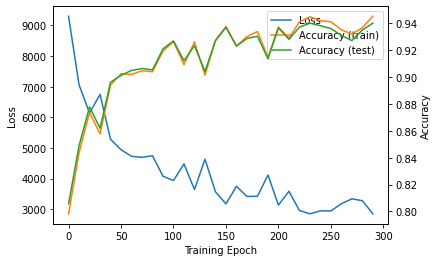

In [21]:
print('no unknowns!')

# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 4], 0.001, 'none', 0.0, 20.0, 32, 0.9, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Ran for only 300 epoch to get a fell for the model. perfromed decently, however, the confusion between normal and fusion beats persists. Lets try to increase l2 penalty. 

Epoch = 10 	loss = 9944.469162791265
Epoch = 20 	loss = 8705.117355274342
Epoch = 30 	loss = 8151.138608625549
Epoch = 40 	loss = 8042.990235614105
Epoch = 50 	loss = 6476.291302497038
Epoch = 60 	loss = 5339.669395226852
Epoch = 70 	loss = 4944.469544032455
Epoch = 80 	loss = 4896.507298209035
Epoch = 90 	loss = 4211.748225587836
Epoch = 100 	loss = 3957.044376134894
Epoch = 110 	loss = 4217.404643892384
Epoch = 120 	loss = 4699.158512198021
Epoch = 130 	loss = 4384.988768510212
Epoch = 140 	loss = 4262.756551579772
Epoch = 150 	loss = 3860.2663161621617
Epoch = 160 	loss = 4494.465930778613
Epoch = 170 	loss = 4203.57121349451
Epoch = 180 	loss = 3327.418794923944
Epoch = 190 	loss = 3661.531889024716
Epoch = 200 	loss = 3261.7342256086713
Epoch = 210 	loss = 4333.523159469204
Epoch = 220 	loss = 3457.560649103488
Epoch = 230 	loss = 3672.3476598458888
Epoch = 240 	loss = 4044.5287413325273
Epoch = 250 	loss = 3282.3972752548884
Epoch = 260 	loss = 3193.696107849178
Epoch = 270 	loss

array([[0.97, 0.01, 0.03, 0.  ],
       [0.02, 0.96, 0.02, 0.  ],
       [0.1 , 0.04, 0.86, 0.  ],
       [0.33, 0.15, 0.02, 0.51]])

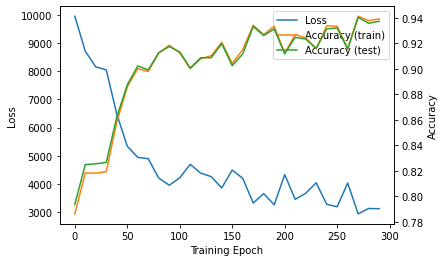

In [22]:
# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 80.0, 32, 0.9, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Increasing l2 increased overall accuracy of fusion beat classification, but also increased number of false negatives by ~8%. After running more trials (not shown) an l2 value of 80 produced the best results compared to the other l2 values. Will adding a l1 penalty help?

Epoch = 10 	loss = 112423.30904446494
Epoch = 20 	loss = 112422.29005372825
Epoch = 30 	loss = 112410.1240208764
Epoch = 40 	loss = 112513.75094322077
Epoch = 50 	loss = 112551.93038677555
Epoch = 60 	loss = 112402.70410369318
Epoch = 70 	loss = 112512.82737542942
Epoch = 80 	loss = 112465.00199000012
Epoch = 90 	loss = 112375.7235450853
Epoch = 100 	loss = 112457.66801427405
Epoch = 110 	loss = 112382.97244585888
Epoch = 120 	loss = 112418.79965554365
Epoch = 130 	loss = 112544.26652167818
Epoch = 140 	loss = 112367.71679845947
Epoch = 150 	loss = 112372.86355932537
Epoch = 160 	loss = 112368.00946267348
Epoch = 170 	loss = 112385.34759573506
Epoch = 180 	loss = 112449.68649300233
Epoch = 190 	loss = 112357.89081285348
Epoch = 200 	loss = 112393.43331171335
Epoch = 210 	loss = 112359.57015711749
Epoch = 220 	loss = 112353.75662723629
Epoch = 230 	loss = 112390.65681314147
Epoch = 240 	loss = 112454.92542640388
Epoch = 250 	loss = 112450.32099272846
Epoch = 260 	loss = 112536.485063332

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

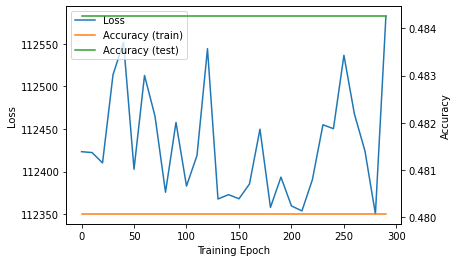

In [24]:
# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 20.0, 80.0, 32, 0.9, ['normal', 100], 'cross-entropy', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

l1 did not help. 

Epoch = 10 	loss = 9561.321319842218
Epoch = 20 	loss = 8982.510584051643
Epoch = 30 	loss = 6929.748934716258
Epoch = 40 	loss = 6592.021749536094
Epoch = 50 	loss = 5742.59299035817
Epoch = 60 	loss = 4271.948403343758
Epoch = 70 	loss = 4327.573960804621
Epoch = 80 	loss = 4215.800878114781
Epoch = 90 	loss = 3591.006766304828
Epoch = 100 	loss = 4385.785073901926
Epoch = 110 	loss = 3078.211036512625
Epoch = 120 	loss = 2902.5954717766504
Epoch = 130 	loss = 3556.9174304441967
Epoch = 140 	loss = 3475.999866998067
Epoch = 150 	loss = 3390.3273618914604
Epoch = 160 	loss = 2817.415605053215
Epoch = 170 	loss = 3374.8164646808527
Epoch = 180 	loss = 2379.1651717540276
Epoch = 190 	loss = 2554.7891670852378
Epoch = 200 	loss = 2386.4233051426513
Epoch = 210 	loss = 2562.1627549936557
Epoch = 220 	loss = 2498.4844790347734
Epoch = 230 	loss = 2259.8229973222565
Epoch = 240 	loss = 2303.02526669606
Epoch = 250 	loss = 2246.0009172458203
Epoch = 260 	loss = 2232.746519394428
Epoch = 270 

array([[0.9 , 0.01, 0.08, 0.  ],
       [0.01, 0.97, 0.02, 0.  ],
       [0.04, 0.04, 0.92, 0.  ],
       [0.2 , 0.22, 0.04, 0.54]])

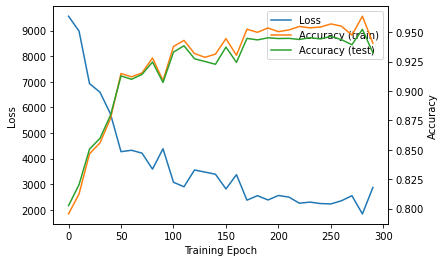

In [36]:
# No l1 or l2 penalties to compare

# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 0.0, 32, 0.9, ['normal', 100], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Performed best with no regularization. 

### Switch it up:  
* Initialize with LeCun and Glorot

Epoch = 10 	loss = 5625.676947339815
Epoch = 20 	loss = 5538.928992170991
Epoch = 30 	loss = 6091.176114045829
Epoch = 40 	loss = 3252.1507761573944
Epoch = 50 	loss = 3102.3986944404155
Epoch = 60 	loss = 3635.2525298024384
Epoch = 70 	loss = 2601.15311528383
Epoch = 80 	loss = 3276.1954488973274
Epoch = 90 	loss = 3086.869587650418
Epoch = 100 	loss = 2304.832026086948
Epoch = 110 	loss = 2414.0332392206865
Epoch = 120 	loss = 2443.169575659931
Epoch = 130 	loss = 2449.552040449753
Epoch = 140 	loss = 2508.6300328728785
Epoch = 150 	loss = 2528.88199608969
Epoch = 160 	loss = 2079.5214837622384
Epoch = 170 	loss = 2376.8007500877075
Epoch = 180 	loss = 2889.247772279257
Epoch = 190 	loss = 2221.489619021543
Epoch = 200 	loss = 1981.4072276828413
Epoch = 210 	loss = 2087.7252373998795
Epoch = 220 	loss = 2374.2232319263176
Epoch = 230 	loss = 1817.6824728219842
Epoch = 240 	loss = 2070.266408741289
Epoch = 250 	loss = 2235.2068834533816
Epoch = 260 	loss = 2191.723634917021
Epoch = 27

array([[0.94, 0.01, 0.05, 0.  ],
       [0.01, 0.98, 0.01, 0.  ],
       [0.03, 0.05, 0.91, 0.  ],
       [0.2 , 0.26, 0.03, 0.51]])

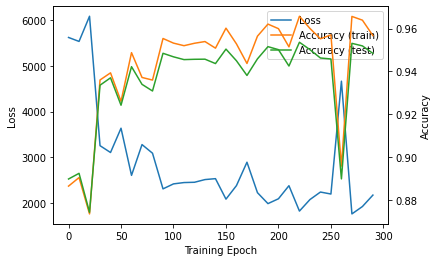

In [37]:
# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 0.0, 32, 0.9, ['LeCun', 'normal'], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Compare to Glorot

Epoch = 10 	loss = 6870.046296752551
Epoch = 20 	loss = 5603.24854227805
Epoch = 30 	loss = 4701.0230674694285
Epoch = 40 	loss = 4401.676389599189
Epoch = 50 	loss = 3617.880660902252
Epoch = 60 	loss = 3376.693908484434
Epoch = 70 	loss = 3346.6597281273384
Epoch = 80 	loss = 3110.874121706221
Epoch = 90 	loss = 2888.9989909545393
Epoch = 100 	loss = 2966.6208865043645
Epoch = 110 	loss = 3070.9513291902845
Epoch = 120 	loss = 2961.776871672518
Epoch = 130 	loss = 3020.9717780397214
Epoch = 140 	loss = 2714.2381670769696
Epoch = 150 	loss = 2505.184754606592
Epoch = 160 	loss = 2523.703217937552
Epoch = 170 	loss = 2295.2054544818566
Epoch = 180 	loss = 3140.7390140358893
Epoch = 190 	loss = 2451.9627833032855
Epoch = 200 	loss = 2713.649322093239
Epoch = 210 	loss = 2369.7593680898626
Epoch = 220 	loss = 2465.57511114516
Epoch = 230 	loss = 2261.904851488212
Epoch = 240 	loss = 2016.9041046686868
Epoch = 250 	loss = 2054.598340241357
Epoch = 260 	loss = 2011.9774243695572
Epoch = 27

array([[0.96, 0.01, 0.03, 0.  ],
       [0.01, 0.97, 0.02, 0.  ],
       [0.05, 0.04, 0.91, 0.  ],
       [0.2 , 0.21, 0.03, 0.56]])

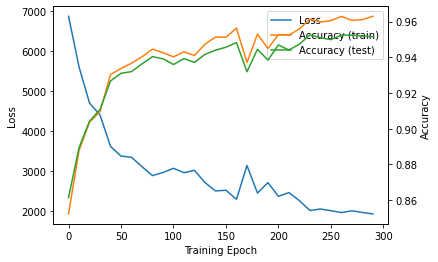

In [42]:
# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 0.0, 32, 0.7, ['Glorot', 'normal'], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 300, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

### Note: Regardless of initilaization method, sigmoid would initialize at a high loss, and result in overall lower accuracies. These trails are not shown, but would generally have accuracies around 85% and struggled with classifying fusion beats. Trials (not shown) also determined that loss function had little impact on performance.

## Final: 
* Best performance:
    * Layers: 32, 128, 64, 32, 16, 4 
    * Step size: 0.001
    * Regularization: 0.0, 0.0
    * Momentum: 0.9, 
    * Initialization: Glorot, normal 
    * Activation: Hyperbolic Tangent
* lets increase epoch to 1000 bc it looked like loss was still decreasing at 300 epoch

Epoch = 10 	loss = 6646.135120244471
Epoch = 20 	loss = 5973.7016914451115
Epoch = 30 	loss = 4080.794681749637
Epoch = 40 	loss = 3201.079728254902
Epoch = 50 	loss = 3286.89259922417
Epoch = 60 	loss = 2853.303808779965
Epoch = 70 	loss = 3843.6285764134554
Epoch = 80 	loss = 2831.2933454194986
Epoch = 90 	loss = 2613.882047744197
Epoch = 100 	loss = 2601.9978283091236
Epoch = 110 	loss = 2274.6280073427647
Epoch = 120 	loss = 2679.0228454468747
Epoch = 130 	loss = 2232.3750541614863
Epoch = 140 	loss = 2787.849368060368
Epoch = 150 	loss = 2183.3440470034875
Epoch = 160 	loss = 1971.7048076405085
Epoch = 170 	loss = 2696.647063269347
Epoch = 180 	loss = 2031.956389303723
Epoch = 190 	loss = 2574.7630772494604
Epoch = 200 	loss = 2060.2446048302045
Epoch = 210 	loss = 2225.2489456509293
Epoch = 220 	loss = 2087.2012092906984
Epoch = 230 	loss = 2672.225907897959
Epoch = 240 	loss = 1866.5427189290608
Epoch = 250 	loss = 1855.7731365446546
Epoch = 260 	loss = 2104.0677839174577
Epoch 

array([[0.96, 0.01, 0.03, 0.  ],
       [0.01, 0.97, 0.02, 0.  ],
       [0.03, 0.04, 0.93, 0.  ],
       [0.2 , 0.19, 0.02, 0.59]])

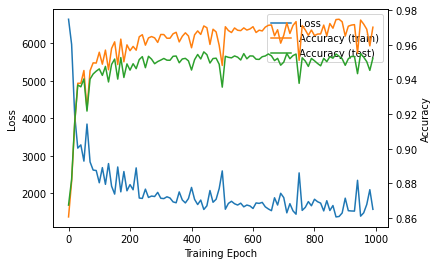

In [43]:
# No l1 or l2 penalties to compare

# fit the model to the training data
model = FFuuNN([32, 128, 64, 32, 16, 4], 0.001, 'none', 0.0, 0.0, 32, 0.9, ['Glorot', 'normal'], 'sum-of-squares', 'hyperbolic tangent')
model.fit(trainX, trainY, testX, testY, 1000, 10)

print("Training set accuracy")
trainY = to_categorical(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

np.round(confusion_matrix(testY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

There was some degree of overfitting starting at around 200 epoch and maintained around a ~2% discrepancy between training and testing accuracy. Finally, lets test this model on the dev set!

# Dev Set Evaluation

In [45]:
print("Dev set accuracy")
devY = to_categorical(devY)
predictedY = model.predict(devX)
predictedY = predictedY.argmax(axis=1)
devY = devY.argmax(axis=1)
print(accuracy_score(devY, predictedY))

np.round(confusion_matrix(devY, predictedY, labels=None, sample_weight=None, normalize='true'), 2)

Dev set accuracy
0.9518487101442044


array([[0.95, 0.01, 0.04, 0.  ],
       [0.01, 0.97, 0.02, 0.  ],
       [0.04, 0.04, 0.93, 0.  ],
       [0.13, 0.2 , 0.06, 0.61]])

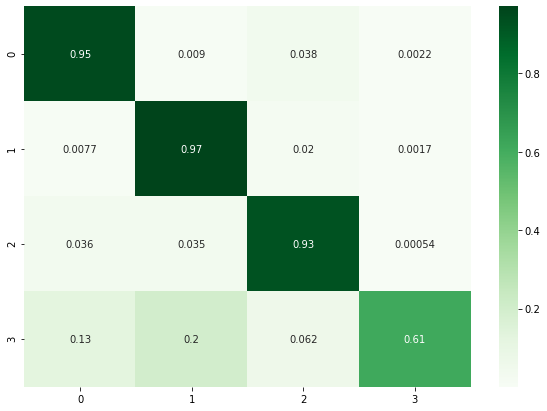

In [53]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(devY, predictedY, normalize='true'), cmap='Greens', annot = True)